<a href="https://colab.research.google.com/github/esther0402/NN_experiments/blob/main/Recurrent_neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recurrent Neural Network

###We will make an LSTM that will capture the (downward and upward) trend of Google stock price.
- We train our model on 5 years of Google stock price from the start of 2012 to end of 2016.
- We will then try to predict the first month of 2017.

###Data we will use
- Google_Stock_Price_Test = stock prices from start of 2012 to end of 2016
- Google_Stock_Price_Train = stock prices from first month of 2017

## Part 1 - Data Preprocessing

### Importing the libraries

In [1]:
import numpy as np #allows to make arrays
import matplotlib.pyplot as plt #visualize our data in charts
import pandas as pd #import datasets and manage easily

### Importing the training set

* We will only train the *training_set*, the RNN will not touch the test set
* We will introduce RNN to the test set once the training is done

In [2]:
#We first import data as a dataframe
dataset_train = pd.read_csv('Google_Stock_Price_Train.csv')

#We make it a NumPy array and select the columns we are interested in
training_set = dataset_train.iloc[:,1:2].values
  #We just chose the open stock price in column 1
    #: means all rows
    #1:2 not 1 (upperbound excluded), because putting just 1 will make it a simple vector not an array
  #.values makes it a NumPy array from a dataframe

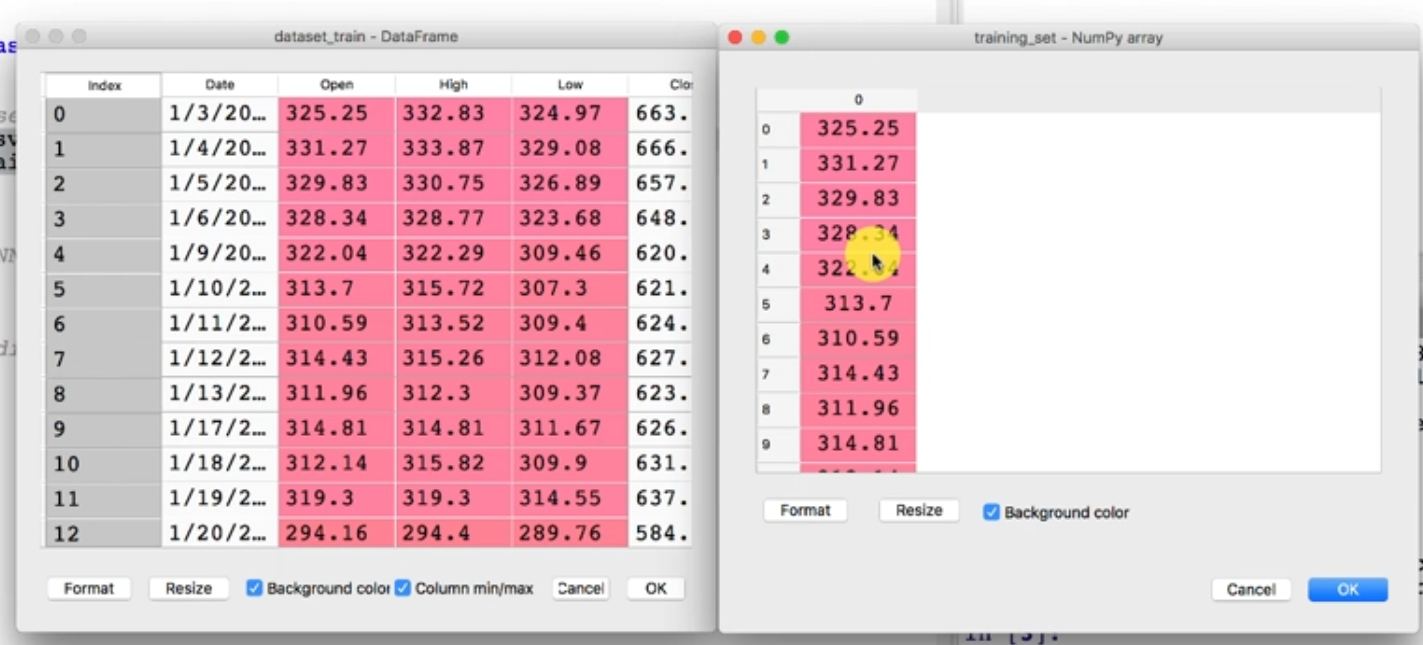

* Left: dataset_train
* Right: training_set (only contains the open stock prices of Google)

### Feature Scaling

* Recap: 2 best ways of feature scaling: Standardization and Normalization
* We use **normalization** as it's more suit for RNNs (esp if you have Sigmoid functions as the activation function in the output layer)

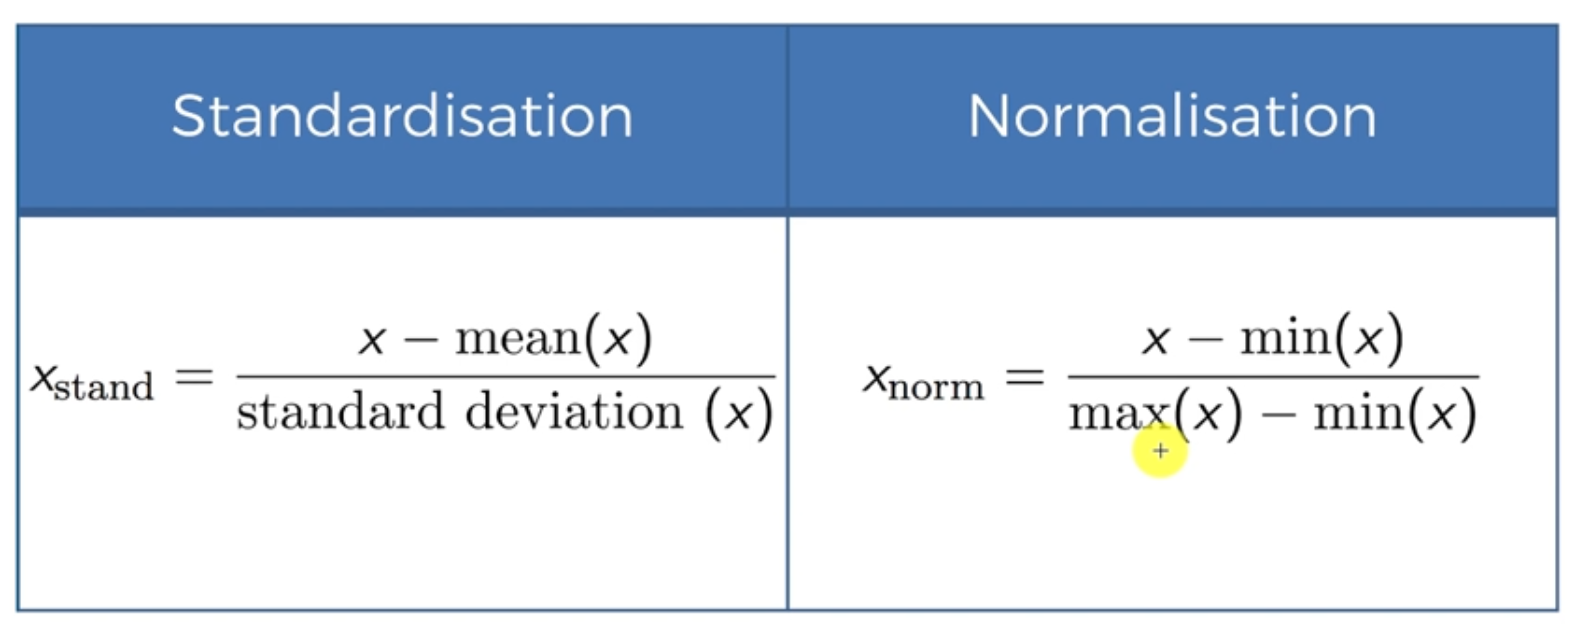

In [3]:
from sklearn.preprocessing import MinMaxScaler
#from the sklearn library we import the preprocessing module, then import the MinMaxScaler class

sc = MinMaxScaler(feature_range = (0, 1))
#All our scaled stock prices will be between 0 and 1 when you use normalization -> so feature range is 0,1
#feature_range = (0,1) is the default value

training_set_scaled = sc.fit_transform(training_set)
#We apply this sc object on our data to effectively apply normalization
#We keep the original dataset with non scaled values
  #fit -> gets the min & max stock price to be able to use the normalization formula
  #transform -> computes the scaled stock prices for each stock prices acc. to the norm. formula

In [ ]:
print(training_set_scaled)

[[0.08581368]
 [0.09701243]
 [0.09433366]
 ...
 [0.95725128]
 [0.93796041]
 [0.93688146]]


### Creating a data structure with 60 timesteps and 1 output

We create a data sturcture specifying what the RNN will need to remember when predicting the next stock price. It will have 60 timesteps and 1 output.
* Timesteps: at each time t, the RNN will look at 60 (just enough to learn) stock prices *before time t* and predict the next output
* 60 timesteps are 60 financial days, since theres 20 financial days in one month, we will look at 3 months

In [4]:
#input of NN, the 60 previous stock prices
x_train = []

#output of NN, the stock price of next financial day
y_train = []

#We populate these 2 entities
for i in range (60, 1258) :
  #since we're getting 60 previous stock prices, we need to start from the 60th
  #1257 is the last index of our observation (we add 1)

  x_train.append(training_set_scaled[i-60:i, 0])
  #we take the stock prices from i-60 to i (every 60th, which excludes upperbound (ex. 1-59))
  # be only have 1 column in training_set_scaled, so it's the 0th column

  y_train.append(training_set_scaled[i, 0])
  #the output y_train will contain the ith day (every 60th financial day)

#we make the lists into NumPy arrays again
x_train, y_train = np.array(x_train), np.array(y_train)

In [ ]:
print(x_train)

[[0.08581368 0.09701243 0.09433366 ... 0.07846566 0.08034452 0.08497656]
 [0.09701243 0.09433366 0.09156187 ... 0.08034452 0.08497656 0.08627874]
 [0.09433366 0.09156187 0.07984225 ... 0.08497656 0.08627874 0.08471612]
 ...
 [0.92106928 0.92438053 0.93048218 ... 0.95475854 0.95204256 0.95163331]
 [0.92438053 0.93048218 0.9299055  ... 0.95204256 0.95163331 0.95725128]
 [0.93048218 0.9299055  0.93113327 ... 0.95163331 0.95725128 0.93796041]]


In [ ]:
print(y_train)

[0.08627874 0.08471612 0.07454052 ... 0.95725128 0.93796041 0.93688146]


### Reshaping

We need to add a new dimension to our NumPy array with the reshape function.
* We add several other indicators too (like volume, close column, etc) through the new dimension. Currently we have 1 indicator, which is the open stock price.
* The dimension we will add is the unit, the number of predictors (indicators) we can use to predict what we want
* This process makes our result compatible with the RNN's input format (so it's necessary).
* We just do this for x_train since it contains the input for the NN



In [5]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
  #1st arg -> what we want to reshape (the numPy array we want to reshape)
  #2nd arg -> new shape, the 3 dimensions
    #batch_size (# of observations) = we get the 1198 entries of x_train = x_train.shape[0] = # of rows of x_train
    #timestep = 60 = x_train.shape[0] = # of columns of x_train
    #number of indicators (we get 1 - the open google stock price)

In [ ]:
print(x_train)

## Part 2 - Building and Training the RNN

We will make a stacked LSTM (not the simple one as we will add layers) with some dropout regularization to prevent overfitting.

### Importing the Keras libraries and packages

In [6]:
from keras.models import Sequential #allows to create an NN object that represents a sequence of layers
from keras.layers import Dense #adds the output layer
from keras.layers import LSTM #adds the LSTM layers
from keras.layers import Dropout #adds the dropout regularization

### Initialising the RNN

We first initialize the RNN as a sequence of layers using the Sqeuantial() class from Keras.

In [7]:
regressor = Sequential()
#Regressor is an object of the sequential class that represents the sequence of layers
#Because we're predicting a continuous output (google stock price), it's not classifier anymore but a regressor

### Adding the first LSTM layer and some Dropout regularisation

We add the first LSTM layer.

In [8]:
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
  #LSTM(3 argments)
    #number of units = # of LSTM cells/neurons (we choose a relevant number), this increases dimensionality
    #return sequences = true because we're building a *stacked* LSTM which will have several LSTM layers
    #input shape = x_train is 3D (observations, timesteps, indicators)
      #But the first one (observations) is taken by default, so we include the 2 remaining dimensions

As mentioned earlier, dropout regularization avoids overfitting. It is a technique where randomly selected neurons are ignored during training. They are “dropped out” randomly.

This means that their contribution to the activation of downstream neurons is temporally removed on the forward pass, and any weight updates are not applied to the neuron on the backward pass.

As a neural network learns, neuron weights settle into their context within the network. Weights of neurons are tuned for specific features, providing some specialization. Neighboring neurons come to rely on this specialization, which, if taken too far, **can result in a fragile model too specialized for the training data.** This reliance on context for a neuron during training is referred to as complex co-adaptations.

In [9]:
regressor.add(Dropout(0.2))
  #add the number of neurons you wanna drop/ignore (dropout rate) for regularization
  #We have 20% dropout (a standard number)

### Adding a second LSTM layer and some Dropout regularisation

From here, we don't have to specify the input shape of the previous LSTM layer because it's recognized automatically.

In [10]:
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

### Adding a third LSTM layer and some Dropout regularisation

In [11]:
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

### Adding a fourth LSTM layer and some Dropout regularisation

In [12]:
regressor.add(LSTM(units = 50))
#We stop making return_ssequences to true because we dont need any more LSTM layers, so we remove the true statement since default is false
regressor.add(Dropout(0.2))

### Adding the output layer

In [13]:
regressor.add(Dense(units = 1))

* For the output layer, we use the Dense class since we're not using an LSTM layer but a classic fully connected layer. We used this for the ANN and CNN too.
* 1 is the # of neurons -> Output should be only one

### Compiling the RNN

We compile the RNN with a powerful optimizer and a weight loss.

In [14]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
  #optimizer = In RNNs, RMSprop optimzier is recommended (for stochastic gradient descent)
    #But we use 'adam' here since it works better for us (it's always a safe choice, also better through experimentation)
  #loss function = not a classifier anymore (so we dont use binary cross entropy) -> we use mean squared error

### Fitting the RNN to the Training set
* Connect our training data with RNN - It is this step that the training will happen.

In [ ]:
regressor.fit(x_train, y_train, epochs = 100, batch_size = 32)
#fit connects our NN to the training set, and executes the training over the specified epochs
#parameters
  #input of NN, the features
  #comparison data, the ground truth
  #number of epochs (number of iterations of training (forward and back propagation))
  #batch size (for each training (forward and back propagation))

The final loss is around ~0.15. We added dropout regularisation in order for this rate to not decrease any further, which induces overfitting

## Part 3 - Making the predictions and visualising the results

### Getting the real stock price of 2017

In [16]:
dataset_test = pd.read_csv('Google_Stock_Price_Test.csv')
real_stock_price = dataset_test.iloc[:, 1:2].values

### Getting the predicted stock price of 2017

We will use our regressor and predict the Google stock prices
* We trained our model to be able to predict the stock price at t + 1 based on the 60 previous stock prices. We will need the 60 previous stock prices in order to do so.
* In order to get the 60 previous stock prices of each day of January 2017, we need both training set and test set. (Some previous stock prices will come from January 2017)
* We have to combine the training set and the test set. We have to use the DataFrames because we cannot touch the original test set -> We need to use the fit_transform method again as our RNN was trained on the scaled values of the training set.

In [18]:
#concatenation of original DataFrames
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
#Two arguments
  #The data you want to concatenate
  #The axis along which we want to make the concatenation, which is the vertical axis (0)

axis = 0 means that you are concatenating the pandas objects along the rows (vertical axis). This is the default option for the concat() method. It will append the rows of dataset_test[‘Open’] below the rows of dataset_train[‘Open’] and return a new DataFrame with the combined rows.

In [19]:
#We will get the inputs, the stock prices of 60 previous days
inputs = dataset_total[len(dataset_total) - len(dataset_test) -60:].values
#len() gets the index
  #dataset_total (index of last day of Jan 2017) - dataset_test = January 3rd
#.values -> into NumPy array

In [20]:
inputs = inputs.reshape(-1,1) #inputs are not shaped
inputs = sc.transform(inputs) #we scale our inputs. No use for 'fit' because it is already fitted

-1 means that you are letting numpy calculate the dimension for you based on the other dimension and the total number of elements.

In [21]:
#Making into 3D format for RNN
x_test = []
for i in range(60, 80): #20 financial days
    x_test.append(inputs[i-60:i, 0])
    #This gets the 60 previous inputs for each of the stock prices of Jan 2017
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [23]:
predicted_stock_price = regressor.predict(x_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

1/1 [==============================] - 0s 48ms/step


After scaling, you would have data that is scaled and your model would output data at the same scale. in order to get back data at the original scale, we use the inverse method.

### Visualising the results

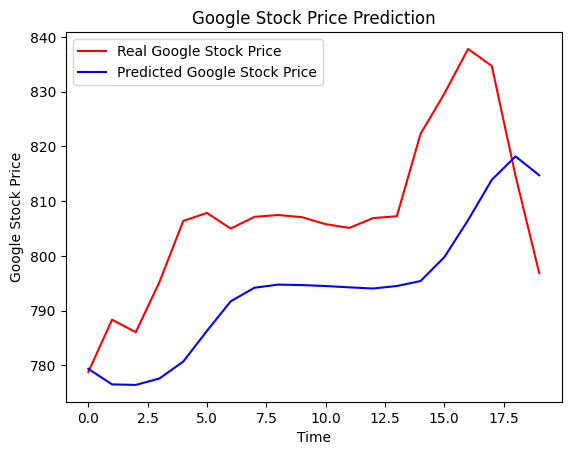

In [25]:
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')

plt.plot(real_stock_price, color = 'red', label = 'Real Google Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Google Stock Price')

plt.legend()
plt.show()